In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

x_train = pd.read_csv('data/features_scaled.csv').drop('Unnamed: 0', axis=1)
x_train_pca = pd.read_csv('data/train_PCA.csv').drop('Unnamed: 0', axis=1)

x_test = pd.read_csv('data/test_data_scaled.csv').drop('Unnamed: 0', axis=1)
x_test_pca = pd.read_csv('data/test_PCA.csv').drop('Unnamed: 0', axis=1)

y = pd.read_csv('data/target_scaled_nontransformed.csv').drop('Unnamed: 0', axis=1)

# Frequentist

First, we use OLS to get a frequentist interprestation of linear regression. This will be split into two parts:

- Regular Features
- PCA

### Regular Features

In [77]:
# Initialize linear regression
import statsmodels.api as sm

x_train_with_intercept = sm.add_constant(x_train)

lg_regular = sm.OLS(y, x_train_with_intercept)

# fit on data
lg_regular_fit = lg_regular.fit()


print(lg_regular_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               spending   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     153.0
Date:                Sun, 19 May 2024   Prob (F-statistic):           2.72e-11
Time:                        01:56:51   Log-Likelihood:                -83.224
No. Observations:                  20   AIC:                             180.4
Df Residuals:                      13   BIC:                             187.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               612.0900      4.30

In [78]:
# do actual prediction with sklearn
from sklearn.linear_model import LinearRegression

lg_regular_sk = LinearRegression().fit(x_train, y)

print(f'Predicted value: {lg_regular_sk.predict(x_test)[0][0]:.2f}')

Predicted value: 890.06


In [79]:
# predicting estimated standard error
RSS = np.sum((y - lg_regular_sk.predict(x_train)) ** 2).values[0]

std_error_hat = np.sqrt(RSS / (7))

lower_bound = lg_regular_sk.predict(x_test)[0][0] - 1.96 * std_error_hat
upper_bound = lg_regular_sk.predict(x_test)[0][0] + 1.96 * std_error_hat

print(f'95% confidence interval: [{lower_bound:.2f}, {upper_bound:.2f}]')

95% confidence interval: [838.64, 941.49]


### PCA

In [80]:
# Initialize linear regression
import statsmodels.api as sm

x_train_pca_with_intercept = sm.add_constant(x_train_pca)

lg_pca = sm.OLS(y, x_train_pca_with_intercept)

# fit on data
lg_pca_fit = lg_pca.fit()

print(lg_pca_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               spending   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     191.3
Date:                Sun, 19 May 2024   Prob (F-statistic):           2.21e-12
Time:                        01:56:59   Log-Likelihood:                -94.365
No. Observations:                  20   AIC:                             194.7
Df Residuals:                      17   BIC:                             197.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         612.0900      6.571     93.145      

In [81]:
# do actual prediction with sklearn
from sklearn.linear_model import LinearRegression

lg_pca_sk = LinearRegression().fit(x_train_pca, y)

print(f'Predicted value: {(lg_pca_sk.predict(x_test_pca))[0][0]:.2f}')

Predicted value: 891.76


In [82]:
# predicting estimated standard error
RSS = np.sum((y - lg_pca_sk.predict(x_train_pca)) ** 2).values[0]

std_error_hat = np.sqrt(RSS / (3))

lower_bound = lg_pca_sk.predict(x_test_pca)[0][0] - 1.96 * std_error_hat
upper_bound = lg_pca_sk.predict(x_test_pca)[0][0] + 1.96 * std_error_hat

print(f'95% confidence interval: [{lower_bound:.2f}, {upper_bound:.2f}]')

95% confidence interval: [754.64, 1028.87]


# Bayesian

Now, we will us MCMC to find a distribution for the year of 2023. We will follow the setup:

$$y = \boldsymbol{\beta_1} \mathbf{X} + \beta_0 + \epsilon$$

Where

$$\boldsymbol{\beta_1} \sim N_p(0, I)$$
$$\beta_0 \sim N(0, 10000)$$
$$\epsilon \sim C$$

are our priors.

In [102]:
x_train

,gdp,population,unemployment_rate,interest_rate,inflation_rate,real_estate_sales
0,-1.549521,-1.739085,-0.053323,-0.216460,-0.417579,-1.210888
1,-1.343705,-1.548823,-0.213292,0.345068,0.554866,-0.859513
2,-1.121316,-1.354759,-0.479906,1.594921,0.554866,-0.580041
3,-0.911270,-1.159646,-0.746521,2.349663,-0.303174,-0.396891
4,-0.733080,-0.959178,-0.426583,1.890779,1.012487,-0.490501
5,-0.653099,-0.761311,0.799844,-0.584774,-0.817998,-0.708924
6,-0.732043,-0.572453,2.186239,-0.747798,-0.417579,-0.858156
7,-0.577591,-0.393404,1.866302,-0.705533,-0.817998,-0.968046
8,-0.428584,-0.212816,1.439718,-0.771950,0.497663,-1.008746
9,-0.251584,-0.026801,1.119781,-0.723647,-0.417579,-0.581397


### Regular Features

In [103]:
y = y.values.reshape(20, )

In [137]:
with pm.Model() as simulated_model:
    # set distirbutions
    error = pm.InverseGamma('error', 0.5, 0.5)
    intercept = pm.Normal('intercept', 612, 1)
    gdp = pm.Normal('gdp', 45, 1)
    population = pm.Normal('population', 21, 1)
    unem_rate = pm.Normal('unem_rate', 5, 1)
    interest_rate = pm.Normal('interest_rate', -6, 1)
    inflation_rate = pm.Normal('inflation_rate', 14, 1)
    re_sales = pm.Normal('re_sales', 61, 1)

    gdp_o = pm.MutableData('gdp_o', x_train['gdp'])
    population_o = pm.MutableData('population_o', x_train['population'])
    unem_rate_o = pm.MutableData('unem_rate_o', x_train['unemployment_rate'])
    interest_rate_o = pm.MutableData('interest_rate_o', x_train['interest_rate'])
    inflation_rate_o = pm.MutableData('inflation_rate_o', x_train['inflation_rate'])
    re_sales_o = pm.MutableData('re_sales_o', x_train['real_estate_sales'])


    res = pm.Normal('res', gdp * gdp_o \
                  + population * population_o \
                    + unem_rate * unem_rate_o \
                        + interest_rate * interest_rate_o \
                            + inflation_rate * inflation_rate_o \
                                + re_sales * re_sales_o + intercept, error, observed=y)


    

In [138]:
with simulated_model:
    simulated_trace = pm.sample(draws=4000, tune=5000, chains=4, target_accept=0.98, random_state=109) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, gdp, population, unem_rate, interest_rate, inflation_rate, re_sales]


Sampling 4 chains for 5_000 tune and 4_000 draw iterations (20_000 + 16_000 draws total) took 11 seconds.


In [139]:
pm.summary(simulated_trace, var_names=['intercept', 'error', 'gdp', 'population', 'unem_rate', 'interest_rate', 'inflation_rate', 're_sales'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,611.996,0.970,610.188,613.827,0.006,0.004,23472.0,10658.0,1.0
error,16.255,2.716,11.645,21.396,0.021,0.016,20004.0,10175.0,1.0
gdp,45.144,0.972,43.291,46.954,0.007,0.005,21463.0,11843.0,1.0
population,21.144,0.958,19.342,22.918,0.006,0.005,22348.0,11947.0,1.0
unem_rate,4.974,0.945,3.129,6.683,0.006,0.005,21535.0,11557.0,1.0
interest_rate,-6.057,0.945,-7.822,-4.283,0.006,0.005,21149.0,11722.0,1.0
inflation_rate,14.079,0.961,12.318,15.893,0.006,0.004,24312.0,11847.0,1.0
re_sales,61.140,0.945,59.427,62.983,0.006,0.004,22706.0,12032.0,1.0


In [140]:
with simulated_model:
    hat_data = pm.sample_posterior_predictive(simulated_trace)
hat_data.posterior_predictive.res[0, :, :].mean(axis=0)

Sampling: [res]


<xarray.DataArray 'res' (res_dim_2: 20)>
array([425.96226951, 470.83669486, 493.23932325, 499.87085332,
       529.74609258, 519.35793978, 523.37467369, 520.49631803,
       545.95051192, 568.29427713, 596.61843612, 620.49003827,
       629.51270848, 656.84062782, 681.30906199, 709.52321485,
       715.68957964, 732.10477601, 861.74755048, 940.0252813 ])
Coordinates:
    chain      int64 0
  * res_dim_2  (res_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19

In [141]:
hat_data.posterior_predictive.res[0, :, :].mean(axis=0)

<xarray.DataArray 'res' (res_dim_2: 20)>
array([425.96226951, 470.83669486, 493.23932325, 499.87085332,
       529.74609258, 519.35793978, 523.37467369, 520.49631803,
       545.95051192, 568.29427713, 596.61843612, 620.49003827,
       629.51270848, 656.84062782, 681.30906199, 709.52321485,
       715.68957964, 732.10477601, 861.74755048, 940.0252813 ])
Coordinates:
    chain      int64 0
  * res_dim_2  (res_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19

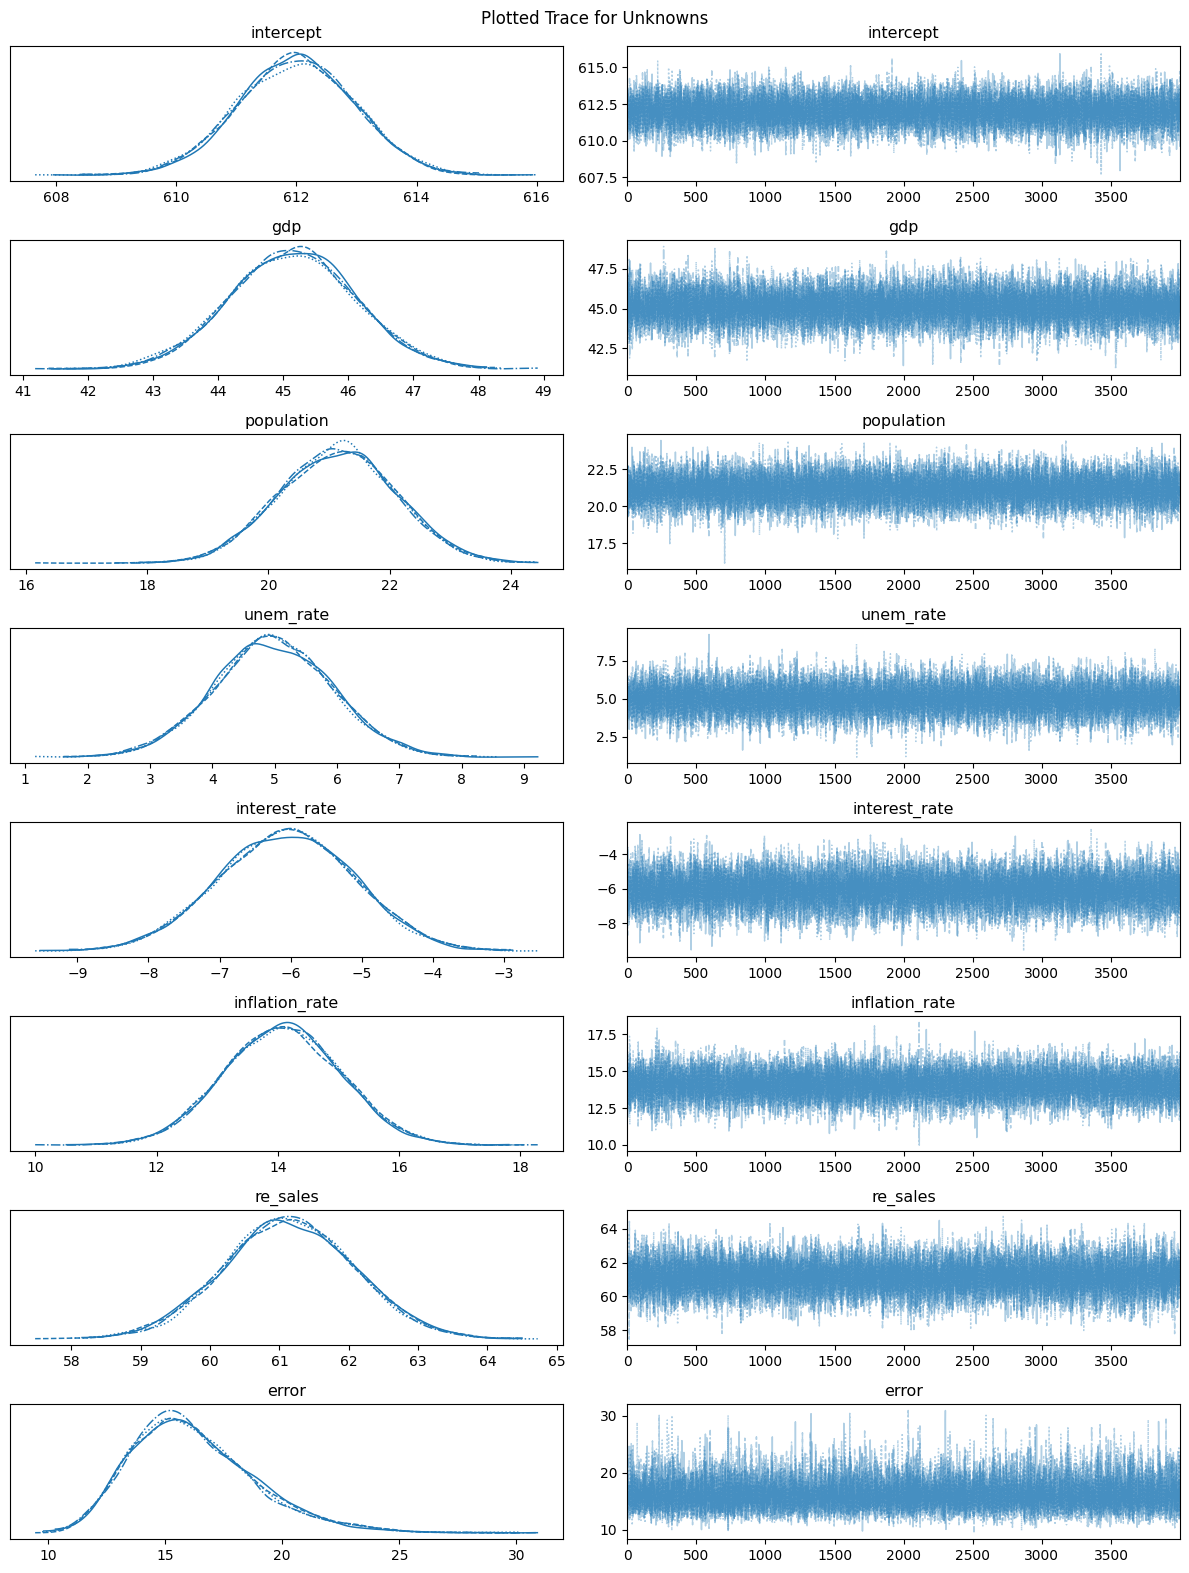

In [142]:
ax = pm.plot_trace(simulated_trace)
ax[0][0].get_figure().suptitle('Plotted Trace for Unknowns')
plt.tight_layout()
plt.show()

In [143]:
# simulate our next output
with simulated_model:
    n_data = {
        'gdp_o' : x_test['gdp'],
        'population_o' : x_test['population'],
        'unem_rate_o' : x_test['unemployment_rate'],
        'interest_rate_o' : x_test['interest_rate'],
        'inflation_rate_o' : x_test['inflation_rate'],
        're_sales_o' : x_test['real_estate_sales']
         
    }

    pm.set_data(n_data)
    posterior = pm.sample_posterior_predictive(simulated_trace)

Sampling: [res]


In [144]:
chains = [posterior.posterior_predictive.res[i][:, 0] for i in range(4)]

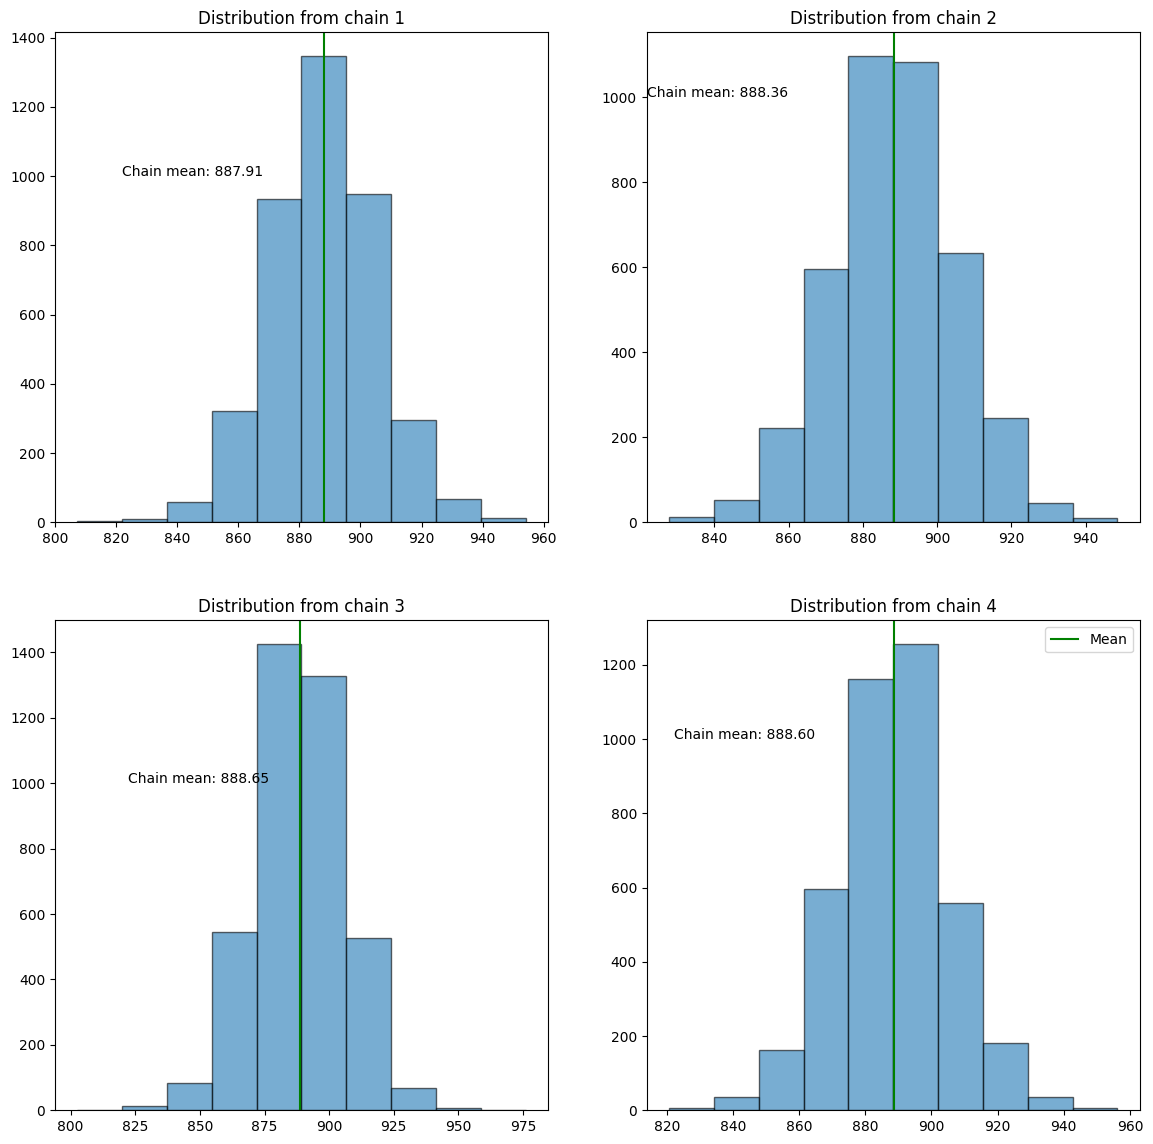

In [145]:
# plot all 4 chain distributions

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(4):
    ax[i // 2][i % 2].hist(chains[i], edgecolor='black', alpha=0.6)
    ax[i // 2][i % 2].set_title(f'Distribution from chain {i + 1}')
    ax[i // 2][i % 2].axvline(chains[i].mean(), c='g', label='Mean')
    ax[i // 2][i % 2].text(822, 1000, f'Chain mean: {chains[i].mean().values:.2f}')

plt.legend()
plt.show()

In [146]:
chains[0].std().values

array(17.39004078)

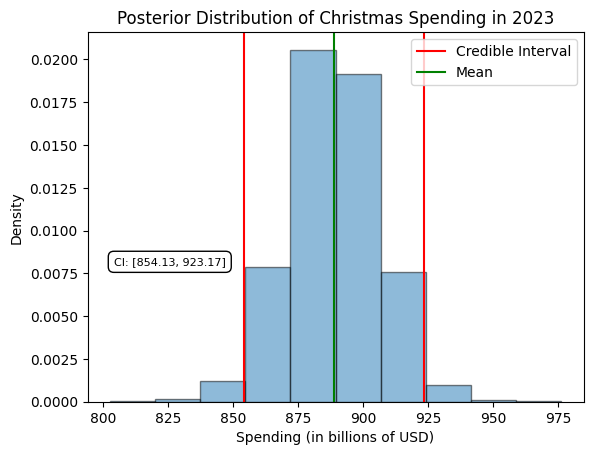

In [151]:
curr_chain = chains[2].values.copy()

plt.hist(curr_chain, edgecolor='k', alpha=0.5, density=True)

plt.axvline(curr_chain.mean() - 2 * curr_chain.std(), c='red')
plt.axvline(curr_chain.mean() + 2 * curr_chain.std(), c='red', label='Credible Interval')
plt.axvline(curr_chain.mean(), c='g', label='Mean')

# Add text box
plt.text(804, 0.008, f'CI: [{(curr_chain.mean() - 2 * curr_chain.std()):.2f}, {(curr_chain.mean() + 2 * curr_chain.std()):.2f}]', fontsize=8, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.legend()

plt.xlabel('Spending (in billions of USD)')
plt.ylabel('Density')
plt.title('Posterior Distribution of Christmas Spending in 2023')
plt.show()


# ARIMA

In [207]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example data
X = x_train_with_intercept
y = y

# Fit ARIMAX model

p = 5
d = 1
q = 0

model = sm.tsa.SARIMAX(y, order=(p, d, q), exog=X, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

print(results.summary())

# # Make prediction for new observation
# predicted_value = model_fit.forecast(steps=1, exog=X_new)
# print(predicted_value)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86827D+00    |proj g|=  1.23108D-02

At iterate    5    f=  2.76682D+00    |proj g|=  1.36961D-02

At iterate   10    f=  2.73831D+00    |proj g|=  1.06892D-01

At iterate   15    f=  2.70173D+00    |proj g|=  9.21979D-03

At iterate   20    f=  2.69107D+00    |proj g|=  1.48442D-01

At iterate   25    f=  2.68190D+00    |proj g|=  1.30821D-02

At iterate   30    f=  2.68032D+00    |proj g|=  3.13420D-02

At iterate   35    f=  2.61977D+00    |proj g|=  1.05715D-01

At iterate   40    f=  2.59517D+00    |proj g|=  8.35272D-02

At iterate   45    f=  2.57921D+00    |proj g|=  6.77028D-02

At iterate   50    f=  2.55566D+00    |proj g|=  3.41834D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [208]:
X_new = x_test.copy()
X_new['const'] = 1

# Make prediction for new observation
forecast = results.get_forecast(steps=1, exog=X_new)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_mean, forecast_ci


(20    653.682011
 dtype: float64,
        lower y     upper y
 20  635.224812  672.139211)

In [218]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
arima_model = ARIMA(y, order=(3, 3, 3))
arima_fitted = arima_model.fit()

# Forecast the next value based on the ARIMA model
forecast = arima_fitted.get_forecast(steps=1)

# Get the forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_mean, forecast_ci

(array([963.95653462]), array([[928.77485514, 999.1382141 ]]))

In [222]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Merge the target variable with the features
combined_data = x_train.copy()
combined_data['spending'] = y

# Define the exogenous variables (features)
exog_vars = ['gdp', 'population', 'unemployment_rate', 'interest_rate', 'inflation_rate', 'real_estate_sales']
exog_data = combined_data[exog_vars]

# Fit the ARIMAX model
arimax_model = SARIMAX(combined_data['spending'], order=(3, 3, 3), exog=exog_data)
arimax_fitted = arimax_model.fit()

# Prepare the exogenous data for the test observation
exog_test_data = x_test[exog_vars]

# Forecast the next value using the ARIMAX model
arimax_forecast = arimax_fitted.get_forecast(steps=1, exog=exog_test_data)

# Get the forecasted mean and confidence intervals

arimax_forecast_mean = arimax_forecast.predicted_mean
arimax_forecast_ci = arimax_forecast.conf_int()

arimax_forecast_mean, arimax_forecast_ci

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09971D+01    |proj g|=  3.65834D+01

At iterate    5    f=  3.48710D+00    |proj g|=  5.31728D-01

At iterate   10    f=  2.95602D+00    |proj g|=  2.81735D-02

At iterate   15    f=  2.93895D+00    |proj g|=  1.71314D-02

At iterate   20    f=  2.91584D+00    |proj g|=  4.93942D-02

At iterate   25    f=  2.88512D+00    |proj g|=  2.08156D-02

At iterate   30    f=  2.87124D+00    |proj g|=  6.34816D-03

At iterate   35    f=  2.85833D+00    |proj g|=  5.72089D-02

At iterate   40    f=  2.85622D+00    |proj g|=  1.38915D-03

At iterate   45    f=  2.85547D+00    |proj g|=  1.46585D-02

At iterate   50    f=  2.85463D+00    |proj g|=  2.87965D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(20    971.209583
 dtype: float64,
     lower spending  upper spending
 20      960.691254      981.727912)